# Liouville Theorem Visualization

HamiltonianPendulum class to generate basic pendulum plots, applied to problems from Taylor, but now solving using Hamilton's equations.

* Last revised 16-Mar-2019 by Dick Furnstahl (furnstahl.1@osu.edu).

For a pendulum, the Lagrangian is

$\begin{align}
  \mathcal{L} = \frac12 m L^2 \dot\phi^2 - mgL(1 - \cos\phi)
\end{align}$

which tells us that the generalized momentum is

$\begin{align}
   \frac{\partial\mathcal{L}}{\partial \dot\phi} = m L^2 \dot\phi \equiv p_\phi
   \;.
\end{align}$

We can invert this equation to find $\dot\phi = p_\phi / m L^2$.
Constructing the Hamiltonian by Legendre transformation we find 

$\begin{align}
  \mathcal{H} &= \dot\phi p_\phi  - \mathcal{L} \\
              &= \frac{p_\phi^2}{m L^2} - \frac12 m L^2 \dot\phi^2 + mgL(1 - \cos\phi) \\
              &= \frac{p_\phi^2}{2 m L^2} + mgL(1 - \cos\phi)
              \;.
\end{align}$

Thus $\mathcal{H}$ is simply $T + V$.  Hamilton's equations are

$\begin{align}
  \dot\phi &= \frac{\partial\mathcal{H}}{\partial p_\phi} = \frac{p_\phi}{m L^2} \\
  \dot p_\phi &= -\frac{\partial\mathcal{H}}{\partial \phi} = -mgL \sin\phi 
  \;.
\end{align}$

A consequence of Liouville's theorem is that if we consider a region in phase space as a set of initial conditions and then evolve each point in that space, the region can change shape but its volume will not change.

We will try this out for the simple pendulum by first picking an area (e.g., a rectangle) in $p_\phi$ by $\phi$ and then selecting random points inside of it.  Each of the points is then propagated a time step by Hamilton's equations and plotted again.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy.random import uniform, rand

from scipy.integrate import solve_ivp
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [4]:
class HamiltonianPendulum():
    """
    Pendulum class implements the parameters and Hamilton's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    omega_0 : float
        natural frequency of the pendulum (\sqrt{g/l} where l is the 
        pendulum length) 
    mass : float
        mass of pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L=1., mass=1., g=1.
                ):
        self.L = L
        self.g = g
        self.omega_0 = np.sqrt(g/L)
        self.mass = mass
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand sides of Hamilton's eqs
        [dq/dt dp/dt] --> [dphi/dt dp_phi/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 2-component vector with y[0] = phi(t) and y[1] = p_phi(t)
            
        Returns
        -------
        
        """
        return [y[1] / (self.mass * self.L**2), 
                -self.mass * self.g * self.L * np.sin(y[0]) 
               ]
    
    
    def solve_ode(self, t_pts, q_0, p_0, 
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [q_0, p_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        q, p = solution.y

        return q, p

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make Liouville theorem visualization

In [7]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
p_phi_vs_time_labels = (r'$t$', r'$p_\phi(t)$')
phase_space_labels = (r'$\phi$', r'$p_\phi$')

L = 1.
g = 1.
mass = 1.

# Instantiate a pendulum 
p1 = HamiltonianPendulum(L=L, g=g, mass=mass)


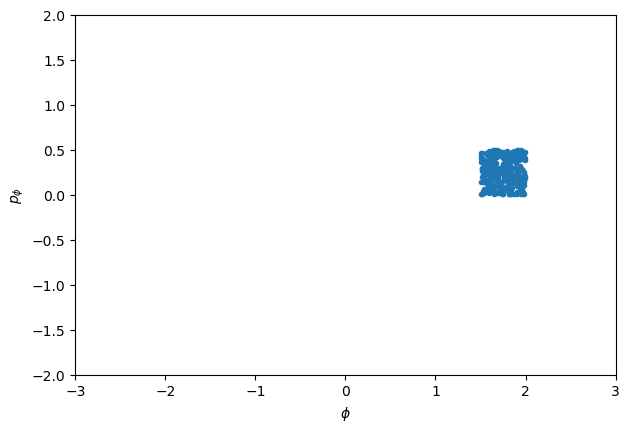

In [8]:
# Generate initial conditions
num_samples = 300
phi_and_p_low = [1.5, 0.0]
phi_and_p_high = [2.0, 0.5]
out = uniform(low=phi_and_p_low, high=phi_and_p_high, size=(num_samples,2))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(out[:, 0], out[:, 1], '.')
ax.set_aspect(1)
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$p_\phi$')
ax.set_xlim(-3., 3.)
ax.set_ylim(-2., 2.)

fig.tight_layout()

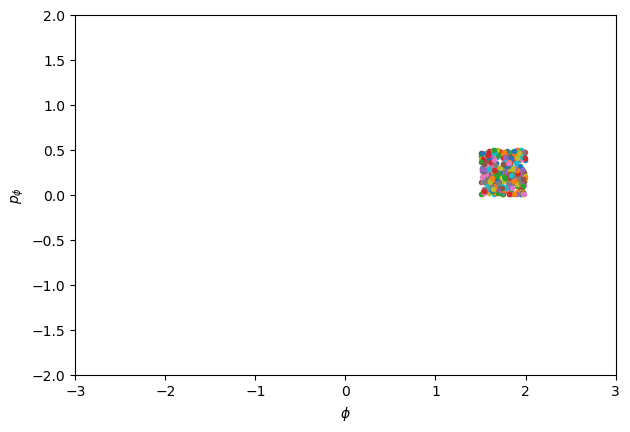

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for phi, p in out:
    ax.plot(phi, p, '.')   

ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$p_\phi$')
ax.set_xlim(-3., 3.)
ax.set_ylim(-2., 2.)
ax.set_aspect(1)

fig.tight_layout()

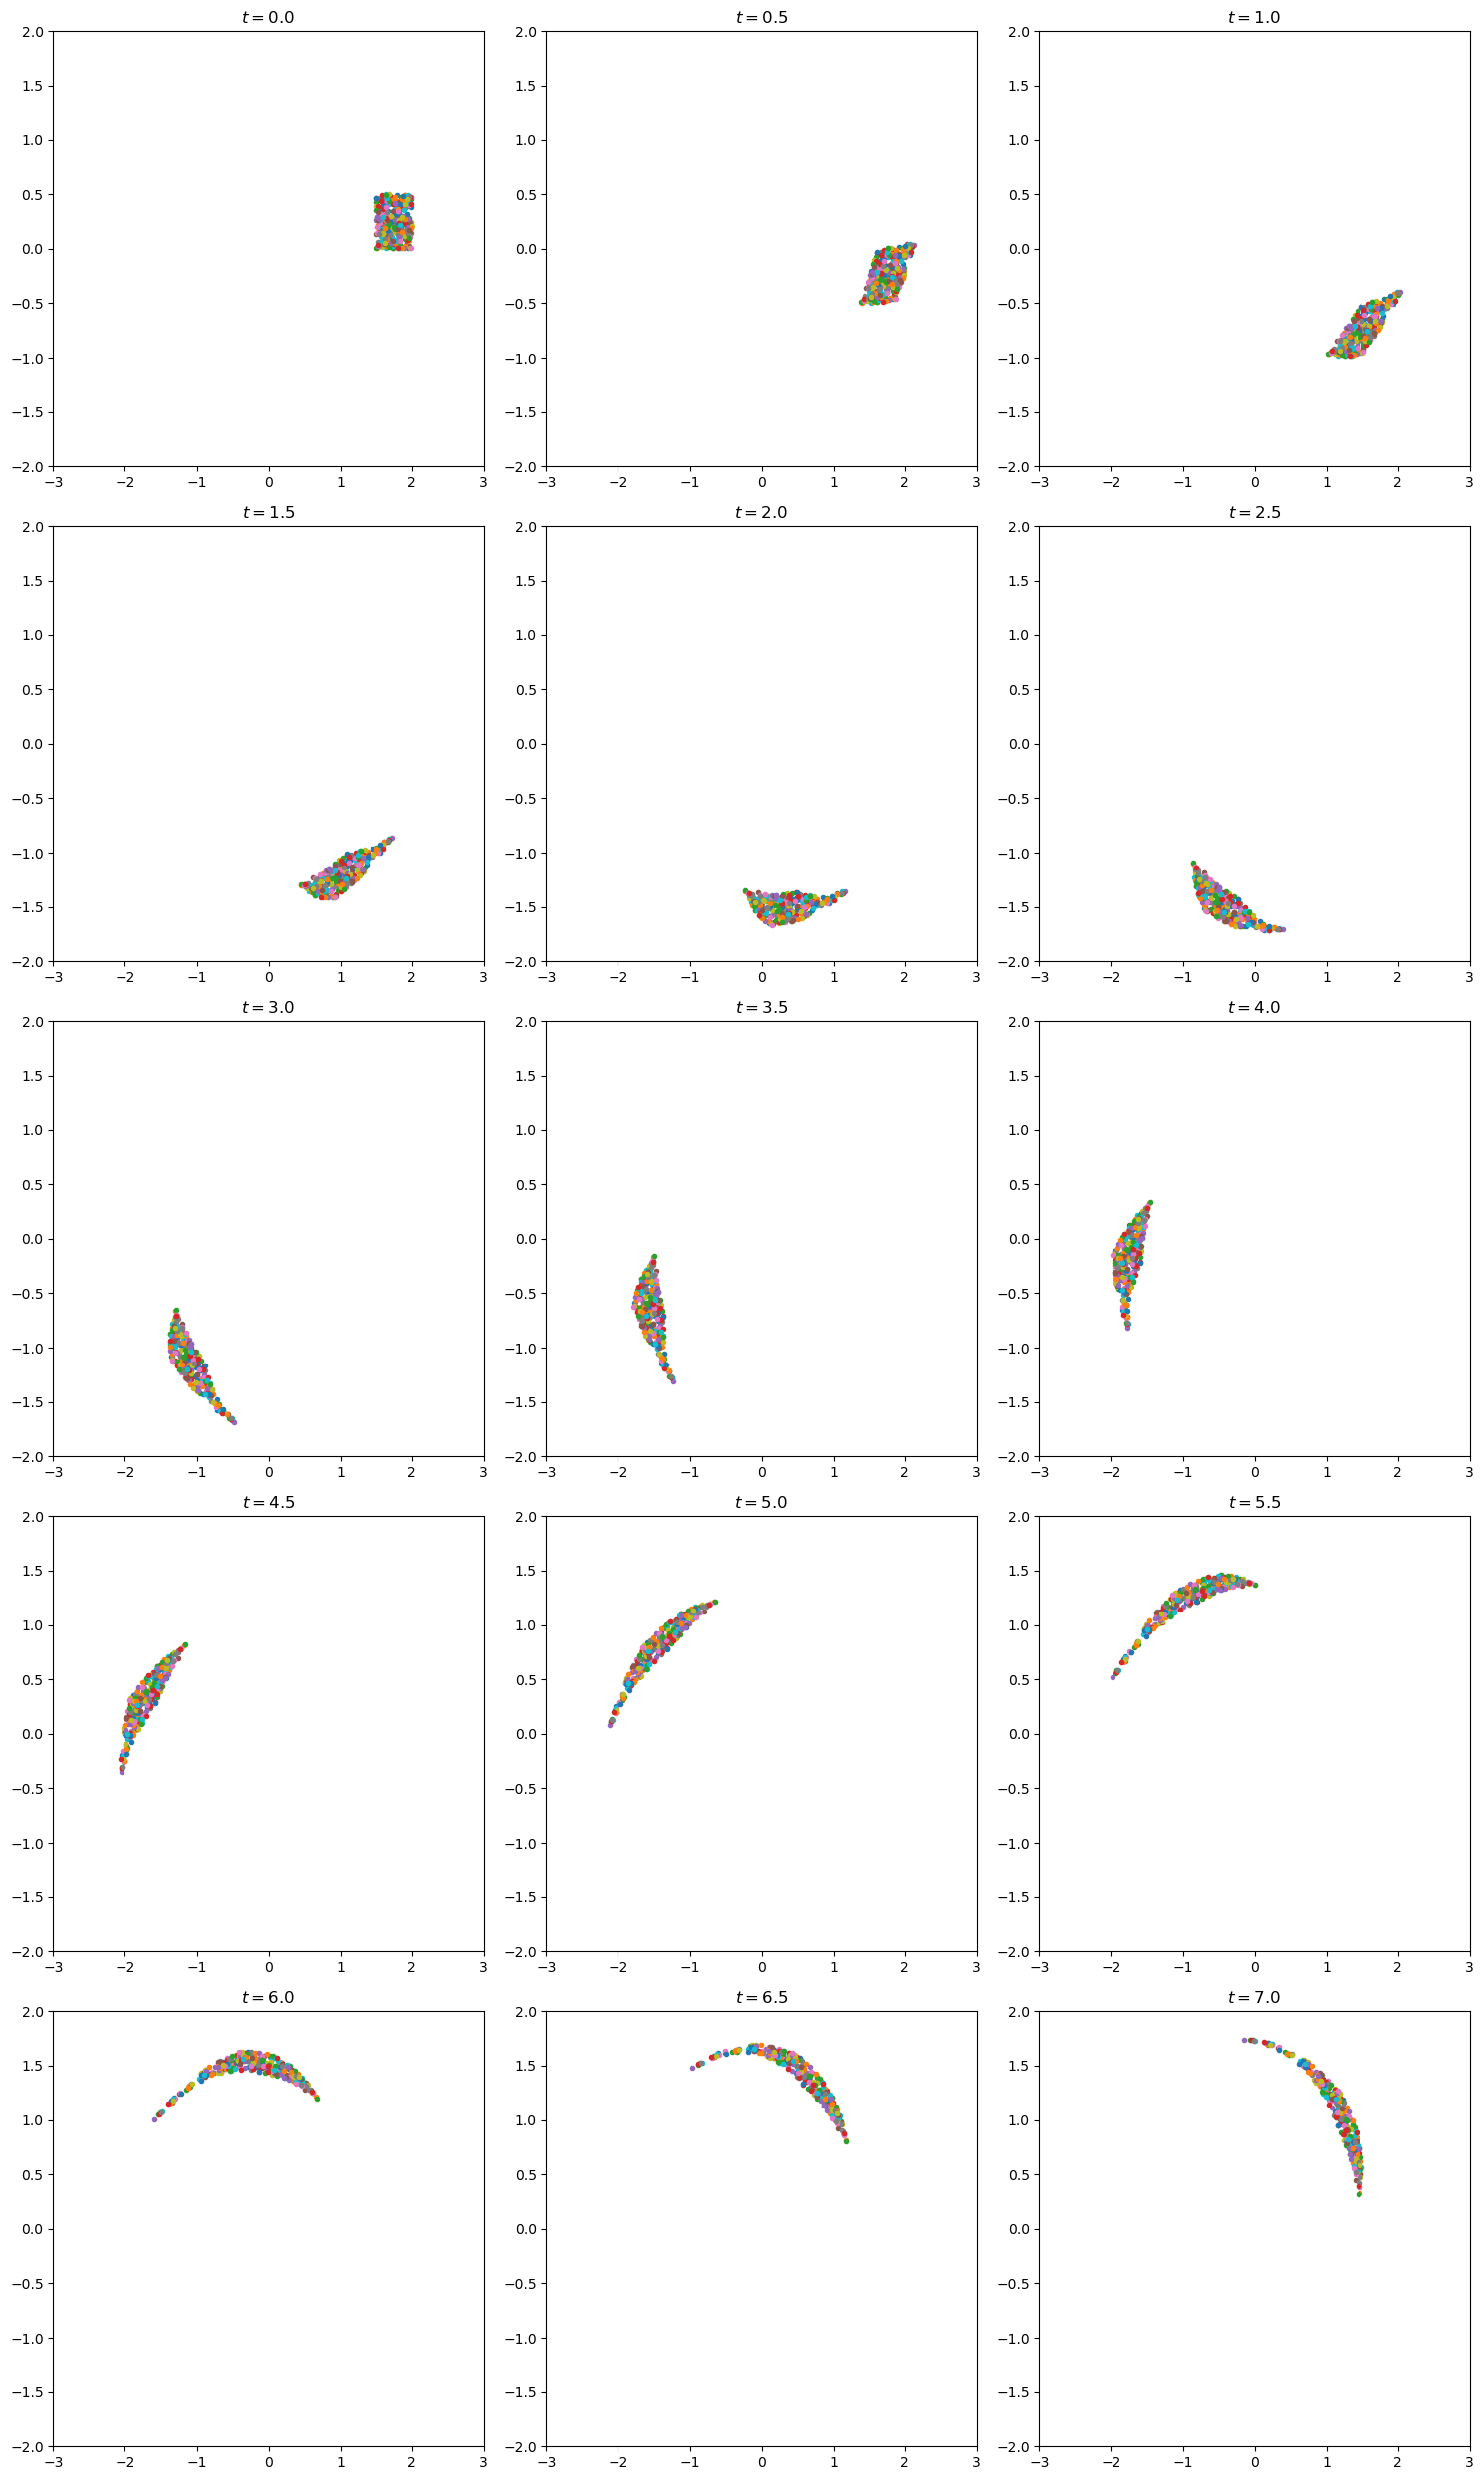

In [10]:
# Common plotting time (generate the full time then use slices)
delta_t = 0.5
t_start = 0.
num_t = 15
t_end = t_start + (num_t - 1) * delta_t  

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# start the plot!
#fig = plt.figure(figsize=(15,5.*num_t/3.))
fig = plt.figure(figsize=(15,5.*num_t/3.))
overall_title = 'Liouville theorem visualization with pendulum'

plot_num = 0
all_orbits = []
for phi_0, p_phi_0 in out:
    phi, p_phi = p1.solve_ode(t_pts, phi_0, p_phi_0)
    all_orbits.append([phi, p_phi])
        
for i in np.arange(num_t):
    ax_c = fig.add_subplot(int(num_t/3), 3, i+1)
    ax_c.set_title(rf'$t = {t_pts[i]:.1f}$')
    for j in np.arange(num_samples):
        phi_now, p_phi_now = all_orbits[j]
        ax_c.plot(phi_now[i], p_phi_now[i], '.')
        ax_c.set_xlim(-3., 3.)
        ax_c.set_ylim(-2., 2.)    

fig.tight_layout()
#fig.suptitle(overall_title, va='top')

fig.savefig('Liouville_test.png', bbox_inches='tight')  